# Differentiable programming for particle physics simulations
#### Roland Grinis - researcher at MIPT Nuclear Physics Methods lab, CTO at GrinisRIT (grinisrit.com)

Code available within `NOA` [github.com/grinisrit/noa](https://github.com/grinisrit/noa) - Bayesian computation algorithms in `C++17` over [LibTorch](https://pytorch.org/cppdocs)

Keep an eye on `KMath` [github.com/mipt-npm/kmath](https://github.com/mipt-npm/kmath) - Maths library in `Kotlin` (thanks to JetBrains Research for support)

## Introduction
In this workshop we will explore the challenges and opportunities that arise in integrating `automatic differentiation (AD)` platforms with simulations in particle physics. 

It is well known that the main drivers of success behind deep learning were the powerful `AD` engines such as [TensorFlow](https://www.tensorflow.org/) and [PyTorch](https://pytorch.org/). Since then, those technologies grew up into full-fledged `differentiable programming (DP)` frameworks capable of tackling a more diversified set of tasks. 

Recently, a very fruitful interaction between `DP`, as we know it in machine learning, and numerical solutions to differential equations started to gather pace. We shall mention here the packages [torchdiffeq](https://github.com/rtqichen/torchdiffeq) and [diffeqflux](https://diffeqflux.sciml.ai/dev/) developed respectively by:

* R. Chen et al., *Neural ordinary differential equations*, Advances in Neural Information Processing Systems (2018)
* C. Rackauckus et al., *Universal differential equations for scientific machine learning*, arXiv preprint arXiv:2001.04385 (2020)

On one hand, we obtain a more flexible framework with a wealth of new tools to tackle a variety of `inverse problems`. On the other hand, many techniques such as the `adjoint sensitivity methods` gave rise to whole new powerful algorithms for `AD`. 

Unsurprisingly, one can find some roots of this story in computational finance as well, see for example:

* M. Giles et al., *Algorithmic Differentiation: Adjoint Greeks Made Easy*. SSRN Electronic Journal (2011)

But in particle physics simulations, a similar picture is left almost unexplored so far. The dynamics are richer than the ones considered before, but we also have more tools at our disposal, such as the `Backward Monte-Carlo` techniques for example. We will give an overview of the theoretical background behind those ideas and provide code examples.

In [13]:
import torch
from torch.utils.cpp_extension import load
import torch.autograd
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
import seaborn as sns
sns.set_style('darkgrid',
                {'axes.facecolor': '.2',
                'figure.facecolor': '0.1',
                'text.color': '.9',
                'grid.color': '.5',
                'xtick.color': '.9',
                'ytick.color': '.9'})

Load `C++17/CUDA` extensions for `PyTorch`:

In [15]:
diffpms = load(name='diffpms',
             sources=['diffpms.cc'],
             extra_include_paths=['../../include'],
             extra_cflags=['-Wall -Wextra -Wpedantic -O3 -std=c++17'],
             verbose=False)

In [16]:
diffpms_cuda = load(name='diffpms_cuda',
             sources=['diffpms.cu'],
             extra_include_paths=['../../include'],
             extra_cflags=['-Wall -Wextra -Wpedantic -O3 -std=c++17'],
             extra_cuda_cflags=['-std=c++17 --extended-lambda'],
             verbose=False) if torch.cuda.is_available() else None

## Backward Monte-Carlo 

This Monte-Carlo technique seeks to reverse the simulation flow from a given final state up to a distribution of initial states. 

Several implementations have been considered, including space radiation problems and more recently muons:

* L. Desorgher et al., *Implementation of the reverse/adjoint Monte Carlo method into Geant4*, Nucl. Instrum. Meth. (2010)
* V. Niess et al., *Backward Monte-Carlo applied to muon transport*, Comput. Phys. Comm. (2018)

The latter is backed by a `C99` muon transport library [PUMAS](https://github.com/niess/pumas). In fact, the need for a `BMC` approach arises naturally in many problems from `muography`:

<img src="muography.png" />

Image credits: Z. X. Zhang et al., *Muography and Its Potential Applications to Mining and Rock Engineering*, Rock Mechanics and Rock Engineering 53, 4893-4907, (2020)

The simulation flow:
\begin{equation}
\textbf{S}_f = \varphi(\textbf{S}_i; \textbf{X})
\end{equation}

maps an initial distribution of states $\textbf{S}_i$ to final one $\textbf{S}_f$, given an auxiliary random variable $\textbf{X}$. The state typically includes position coordinates, momentum direction and kinetic energy.

The flow $\varphi$ induces a transition distribution $\tau$ which one can use to compute the stationary flux of particles:
\begin{equation}
\phi(\textbf{s}_f) = \int \tau(\textbf{s}_f; \textbf{s}_i) \phi(\textbf{s}_i)d\textbf{s}_i
\end{equation}

at a given final state $\textbf{s}_f$. Backward Monte-Carlo is the art and science for evaluating the above integral.  

In fact, if the map $\varphi$ is invertible, one can estimate:
\begin{equation}
\phi(\textbf{s}_f) \simeq \frac{1}{N} \sum_{k=1}^N \omega_{k} \phi(\textbf{s}_{i,k})
\end{equation}

where $\textbf{s}_{i,k} = \varphi^{-1}(\textbf{s}_f; x_k)$ for a draw $x_k \sim \textbf{X}$ and:
\begin{equation}
\omega_{k} = det(\nabla_{\textbf{s}_f}\varphi^{-1})|_{x_k}
\end{equation}


In practice, the flow $\varphi$ is broken down into a sequence of $n$ steps:
\begin{equation}
\textbf{s}_{0,k} = \varphi_1^{-1} \circ \varphi_2^{-1} \circ \dots \circ \varphi_n^{-1} (\textbf{s}_n; x_{n,k})
\end{equation}

and so we get:
\begin{equation}
\omega_{k} = \prod_{j=1}^{n}det(\nabla_{\textbf{s}_j}\varphi_j^{-1})|_{x_{j,k}}
\end{equation}

Unfortunately, the simulation flow is not always invertible and one has to rely on `biasing techniques`. In such situation, we need to construct a regularised version $\varphi_{b}$ of the flow, together with its transition density  $\tau_b$. Then, provided the Radon–Nikodym derivative of $\tau$ exists we can set: 
\begin{equation}
\omega_{k} = \frac{\tau(\textbf{s}_f; \textbf{s}_i)}{\tau_b(\textbf{s}_f; \textbf{s}_i)} det(\nabla_{\textbf{s}_f}\varphi_b^{-1})|_{x_k}
\end{equation}

where the initial state is obtained as $\textbf{s}_{i,k} = \varphi_b^{-1}(\textbf{s}_f; x_k)$.

Of special interest to us is the case of mixture densities:
\begin{equation}
\tau(\textbf{s}_f; \textbf{s}_i) = \sum_{\ell=1}^{m} p_{\ell}(\textbf{s}_i) \tau_{\ell}(\textbf{s}_f; \textbf{s}_i) 
\end{equation}

for a partition of unity of the state space $\sum_{{\ell}=1}^{m} p_l \equiv 1$. 

On has to construct an apriori partition of unity $\sum_{\ell=1}^{m} p_{\ell, b} \equiv 1$. It is used to choose the component $\ell_0$ to evolve with the flow backwards, giving:
\begin{equation}
\omega_{k} = \frac{p_{\ell_0}(\textbf{s}_i)\tau_{\ell_0}(\textbf{s}_f; \textbf{s}_i)}{p_{\ell_0,b}(\textbf{s}_f)\tau_{\ell_0, b}(\textbf{s}_f; \textbf{s}_i)} det(\nabla_{\textbf{s}_f}\varphi_{\ell_0,b}^{-1})|_{x_{\ell_0,k}} 
\end{equation}

and $\textbf{s}_{i,k} = \varphi_{\ell_0,b}^{-1}(\textbf{s}_f; x_k)$.

In [17]:
knode = torch.tensor([0.,5., 10.])
detector =  torch.zeros(2)

In [18]:
def level_set(t, node, x):
    zz02 = (-node[2] * torch.log(t)) - (x - node[0]).pow(2)
    zz0 =  torch.sqrt(zz02[zz02 > 0])
    xs = x[zz02 > 0]
    zs = node[1] - zz0
    return xs, zs

def plot_detector(detector, node_param, x = torch.linspace(-5., 5., 500)):
    plt.figure(figsize=(20,10))

    for t in torch.linspace(0.01,0.99, 50):
        xs, zs = level_set(t, node_param, x)
        plt.plot(xs.numpy(), zs.numpy(), 'C1',alpha=.5 + 0.5*t.item())

    plt.plot(detector[0].numpy(), detector[1].numpy(), '.C3',markersize=50, label='detector',alpha=0.9)
    
    plt.legend(fontsize=20)
    plt.xlim([-5.,5.]) 
    plt.ylim([-1.,4.5])

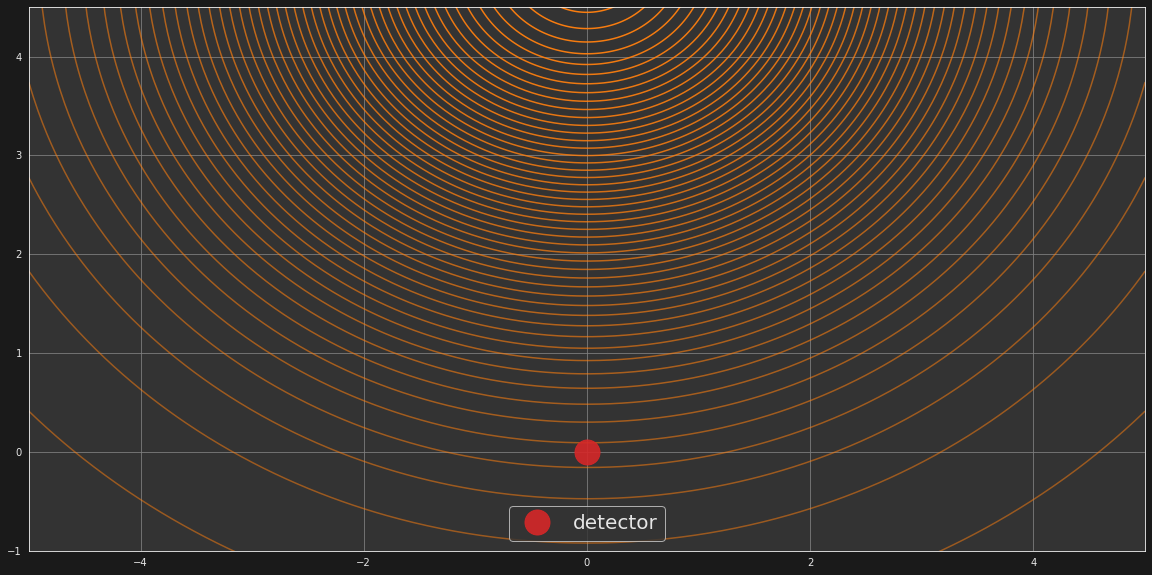

In [19]:
plot_detector(detector, knode)

In [21]:
PI = 2 * torch.acos(torch.tensor(0.))
thetas = PI * torch.tensor([0.1,0.0, -0.08]) 

In [22]:
def mix_density(states, node):
    return torch.exp(-(states - node[:2]).pow(2).sum(-1) / node[2].abs())

In [36]:
rot(thetas)

tensor([[[ 0.9511, -0.3090],
         [ 0.3090,  0.9511]],

        [[ 1.0000, -0.0000],
         [ 0.0000,  1.0000]],

        [[ 0.9686,  0.2487],
         [-0.2487,  0.9686]]])

In [23]:
def rot(theta):
    n = theta.numel()
    c = torch.cos(theta)
    s = torch.sin(theta)
    return torch.stack([c,-s, s, c]).T.view((n,2,2))

In [24]:
def backward_mc(theta, node, npar):
    length1 =  1.0 - 0.2 * torch.rand(npar)
    rot1 = rot(theta)
    step1 = torch.stack([torch.zeros(npar),  length1]).T
    step1 = rot1.matmul(step1.view((npar, 2,1))).view((npar, 2))
    state1 = detector + step1
    
    material_A = 0.01
    material_B = 0.9

    biasing = torch.randint(0,2, (npar,))
    density = mix_density(state1, node)
    weights = torch.where(biasing > 0, (density/0.5) * material_A, ((1 - density)/0.5) * material_B) 
        * torch.exp(-0.01*length1) 
    
    length2 =  1.0 - 0.2 * torch.rand(npar)
    rot2 = rot(0.05 * PI * (torch.rand(npar) - 0.5))
    step2 = length2.view((npar,1)) * step1 / length1.view((npar,1))
    step2 = rot2.matmul(step2.view((npar,2,1))).view((npar, 2))
    state2 = state1 + step2

    biasing = torch.randint(0,2, (npar,))
    density = mix_density(state2, node)
    weights *= torch.where(biasing > 0, (density/0.5) * material_A, ((1 - density)/0.5) * material_B) * torch.exp(-0.01*length2) 
    
    return weights, [state1, state2]

In [25]:
bmcs = []
for theta in thetas:
    _, bmc = backward_mc(theta, knode, 10)
    bmcs.append(torch.stack(bmc).transpose(0,1))

In [26]:
def plot_particles(bmc):
    for particle in bmc:
        plt.plot(particle[-1][0].numpy(), particle[-1][1].numpy(), '.C0',markersize=30, alpha=0.6)
        trajectory = torch.cat([detector.reshape(1,2), particle]).T
        plt.plot(trajectory[0].numpy(),trajectory[1].numpy(), 'C0', alpha=0.9) 
        
def plot_bmc(bmc_data, detector, node_param):
    plot_detector(detector, node_param)
    for bmc in bmc_data:
        plot_particles(bmc)

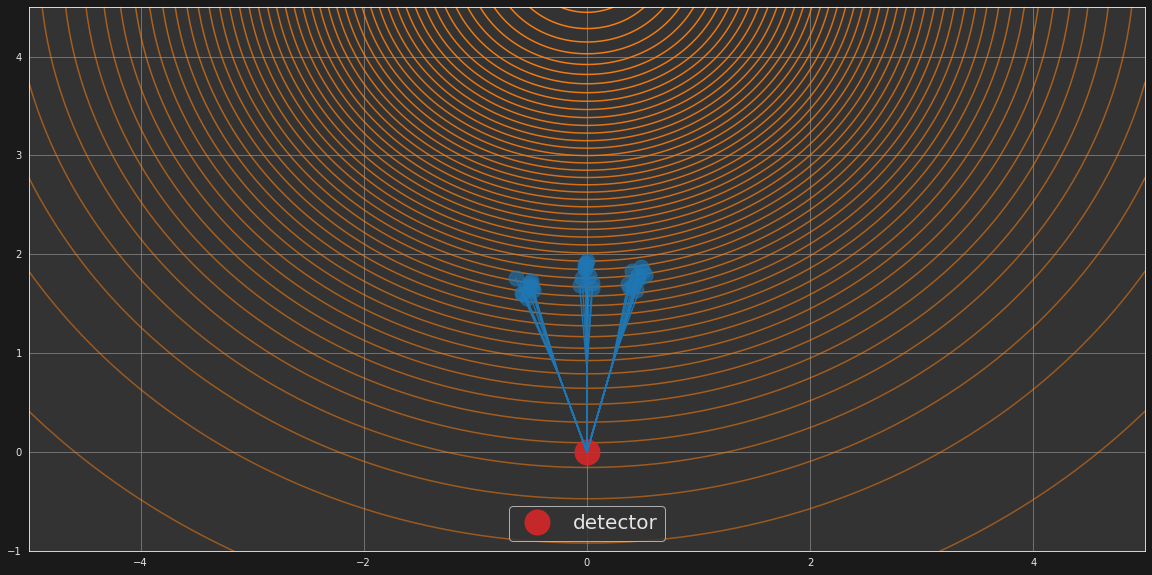

In [27]:
plot_bmc(bmcs, detector, knode)

In [37]:
for theta in thetas:
    print(f'Flux at {round(theta.item(),2)}: {backward_mc(theta, knode, 100000)[0].mean()}')

Flux at 0.31: 0.44150835275650024
Flux at 0.0: 0.41756826639175415
Flux at -0.25: 0.43584609031677246


## Differentiable Programming

In [50]:
observed_flux = torch.tensor([0.46, 0.49, 0.527])

In [51]:
def log_prob_flux(node_params, n=100000):
    log_prob = torch.tensor(0.)
    for i in range(len(thetas)):
        log_prob += (observed_flux[i] - backward_mc(thetas[i], node_params, n)[0].mean()).pow(2) / 0.01
    return - log_prob

In [52]:
def eval_gradient(node_params, n=100000):
    nodeg = node_params.detach().requires_grad_()
    pflux = - log_prob_flux(nodeg,n)
    dpflux = torch.autograd.grad(outputs=pflux, inputs=nodeg)[0]
    return dpflux

In [53]:
nrng = torch.linspace(1, 100000, 101).int()
grad_conv = []
for i in range(nrng.numel()):
    grad_conv.append(eval_gradient(knode, nrng[i].item())[0])

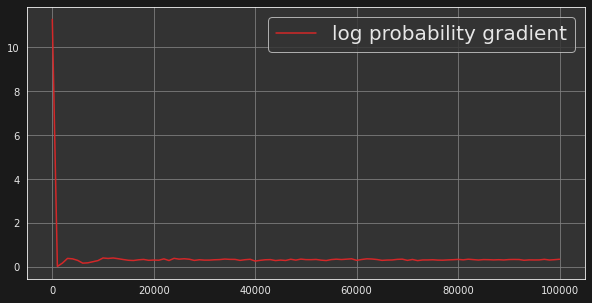

In [54]:
plt.figure(figsize=(10,5))
plt.plot(nrng.numpy(), torch.stack(grad_conv).numpy(), 'C3', label='log probability gradient',alpha=0.99)
plt.legend(fontsize=20)
plt.show()

In [55]:
nu = 0.05
N = 601
gdescent = torch.zeros(N) 

In [56]:
inode = torch.tensor([5.,5.,10.]) 
new_knode = inode - nu * eval_gradient(inode)  
res = []
for i in range(N):
    g = eval_gradient(new_knode)
    new_knode -= nu * g / (g.norm() + 1.0)
    gdescent[i] = - log_prob_flux(new_knode)
    if i % 50 == 0:
        print(f'log probability : {gdescent[i]}')
        print(f'node {i} : {new_knode}')
    if i > (N-100):
        res.append(new_knode.detach().clone())

log probability : 19.406612396240234
node 0 : tensor([ 4.6993,  4.7850, 10.1125])
log probability : 1.8454630374908447
node 50 : tensor([ 3.1554,  3.8680, 10.5958])
log probability : 1.5767207145690918
node 100 : tensor([ 2.6936,  4.4022, 10.7831])
log probability : 1.1569864749908447
node 150 : tensor([ 2.0871,  4.8872, 10.9186])
log probability : 0.9181673526763916
node 200 : tensor([ 1.3871,  5.2479, 11.0065])
log probability : 0.5521390438079834
node 250 : tensor([ 0.6790,  5.4232, 11.0602])
log probability : 0.3156903386116028
node 300 : tensor([ 0.0483,  5.4913, 11.0802])
log probability : 0.1821814924478531
node 350 : tensor([-0.4505,  5.4650, 11.0842])
log probability : 0.09402623772621155
node 400 : tensor([-0.8308,  5.4060, 11.0787])
log probability : 0.04658999294042587
node 450 : tensor([-1.1067,  5.3329, 11.0714])
log probability : 0.017820468172430992
node 500 : tensor([-1.3048,  5.2752, 11.0624])
log probability : 0.03197251260280609
node 550 : tensor([-1.4463,  5.2274, 

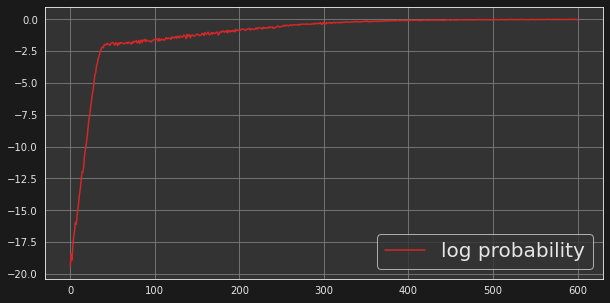

In [57]:
plt.figure(figsize=(10,5))
plt.plot(torch.arange(N).numpy(), -gdescent.numpy(), 'C3', label='log probability',alpha=0.99)
plt.legend(fontsize=20)
plt.show()

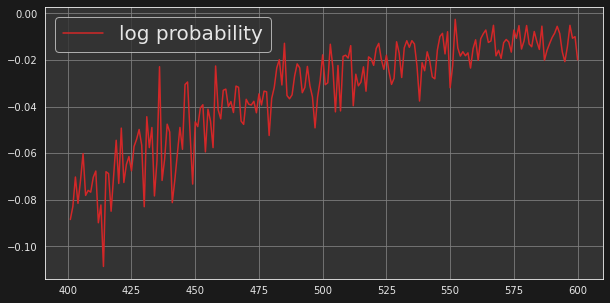

In [58]:
plt.figure(figsize=(10,5))
plt.plot(torch.arange(N).numpy()[-200:], -gdescent.numpy()[-200:], 'C3', label='log probability',alpha=0.99)
plt.legend(fontsize=20)
plt.show()

In [59]:
optimal_node = torch.stack(res[-50:]).mean(0)
optimal_node

tensor([-1.4991,  5.2075, 11.0525])

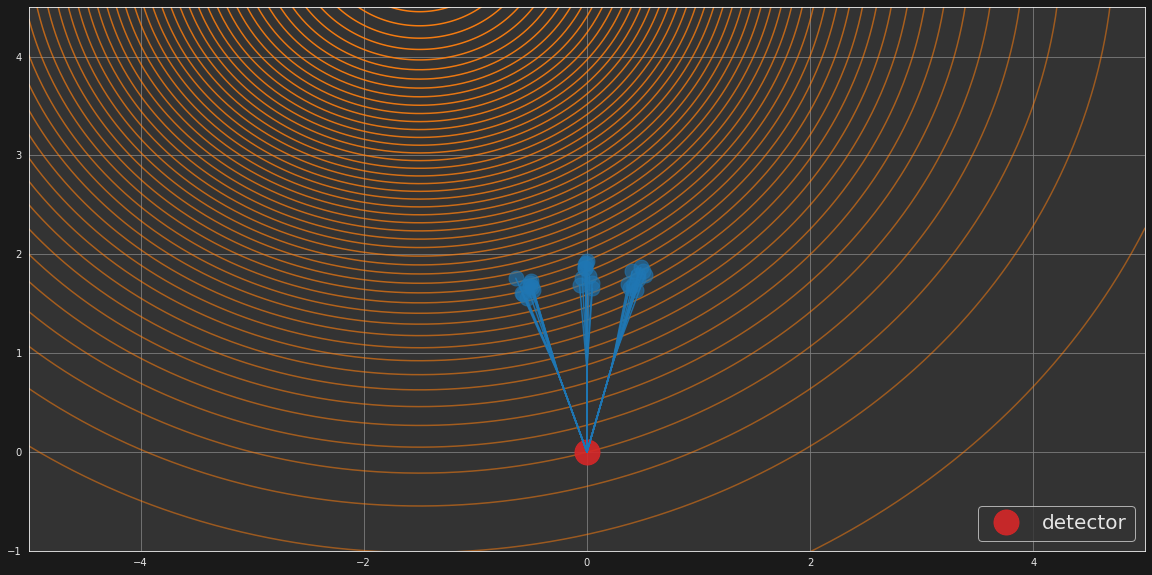

In [60]:
plot_bmc(bmcs, detector, optimal_node)

## Adjoint sensitivity method

Consider an ODE: 
\begin{equation}
\frac{dx}{dt} = f(t, x(t), \theta)
\end{equation}

and imagine that we want to compute the gradient of some scalar function:
\begin{equation}
\mathcal{L}(x(t_1)) = \mathcal{L} \left( x(t_0) + \int_{t_0}^{t_1}f(t, x(t), \theta)dt\right)
\end{equation}

with respect to the parameters $\theta$. 

An efficient way to tackle this task is to introduce the adjoint:
\begin{equation}
a(t) =  \nabla_{x(t)}\mathcal{L}
\end{equation}

which satisfies the adjoint ODE:
\begin{equation}
\frac{da}{dt} = - a(t) \cdot \nabla_x f(t, x(t), \theta)
\end{equation}

The desired gradient is given then by a backward in time integral:
\begin{equation}
\nabla_{\theta}\mathcal{L} = - \int_{t_1}^{t_0} a(t) \cdot \nabla_{\theta} f(t, x(t), \theta)dt
\end{equation}

Reference: L. S. Pontryagin et al., *The mathematical theory of optimal processes* (1962)

```cpp
inline const auto PI = 2.f * torch::acos(torch::tensor(0.f));

inline torch::Tensor rot(const torch::Tensor &theta){
    const auto n = theta.numel();
    const auto c = torch::cos(theta);
    const auto s = torch::sin(theta);
    return torch::stack({c,-s, s, c}).t().view({n,2,2});
}
```

```cpp
inline torch::Tensor mix_density(const torch::Tensor &states, const torch::Tensor &node){
    return torch::exp(-(states - node.slice(0,0,2)).pow(2).sum(1) / node[2].abs());
}
```

```cpp

inline std::tuple<torch::Tensor, torch::Tensor> backward_mc_grad(
        torch::Tensor theta,
        torch::Tensor node) {
    const auto npar = 1;
    const auto detector = torch::zeros(2);
    auto bmc_grad = torch::zeros_like(node);

    const auto material_A = 0.01f;
    const auto material_B = 0.9f;

    const auto length1 =  1.f - 0.2f * torch::rand(npar);
    const auto rot1 = rot(theta);
    auto step1 = torch::stack({torch::zeros(npar),  length1}).t();
    step1 = rot1.matmul(step1.view({npar, 2,1})).view({npar, 2});
    const auto state1 = detector + step1;

    auto biasing = torch::randint(0,2, {npar});

    auto nodeg = node.detach().requires_grad_();
    auto densityg = mix_density(state1, nodeg);
    auto weightsg =
            torch::where(biasing > 0,
                         (densityg/0.5) * material_A,
                         ((1 - densityg)/0.5) * material_B) * torch::exp(-0.01f*length1);
    bmc_grad += torch::autograd::grad({weightsg}, {nodeg})[0];
    auto weights = weightsg.detach();

    const auto length2 =  1.f - 0.2f * torch::rand(npar);
    const auto rot2 = rot(0.05f * PI * (torch::rand(npar) - 0.5f));
    auto step2 = length2.view({npar,1}) * step1 / length1.view({npar,1});
    step2 = rot2.matmul(step2.view({npar,2,1})).view({npar, 2});
    const auto state2 = state1 + step2;

    biasing = torch::randint(0,2, {npar});

    nodeg = node.detach().requires_grad_();
    densityg = mix_density(state2, nodeg);
    weightsg =
            torch::where(biasing > 0,
                         (densityg/0.5) * material_A,
                         ((1 - densityg)/0.5) * material_B) * torch::exp(-0.01f*length2);
    const auto weight2 = weightsg.detach();
    bmc_grad = weights * torch::autograd::grad({weightsg}, {nodeg})[0] + weight2 * bmc_grad;
    weights *= weight2;

    return std::make_tuple(weights, bmc_grad);
}

```

In [61]:
torch.manual_seed(3)
diffpms.backward_mc_grad(thetas[1], knode)

(tensor([1.5430]), tensor([-0.0139,  0.9203, -0.1555]))

In [62]:
torch.manual_seed(3)
knodeg = knode.clone().requires_grad_()
flux = backward_mc(thetas[1], knodeg, 1)[0]
print(flux)
dflux = torch.autograd.grad(outputs=flux, inputs=knodeg)[0]
dflux

tensor([1.5430], grad_fn=<MulBackward0>)


tensor([-0.0139,  0.9203, -0.1555])

## Tensor Operations

In [4]:
kinetic_energies = torch.linspace(1e-3, 1e6, 1000).double()
recoil_energies = 0.0505 * kinetic_energies

In [5]:
kinetic_energies_gpu = kinetic_energies.cuda()
recoil_energies_gpu = recoil_energies.cuda()

In [6]:
kinetic_energies_gpu[:5]

tensor([1.0000e-03, 1.0010e+03, 2.0020e+03, 3.0030e+03, 4.0040e+03],
       device='cuda:0', dtype=torch.float64)

In [7]:
brems_gpu = diffpms_cuda.bremsstrahlung(kinetic_energies_gpu, recoil_energies_gpu);
brems_gpu[:5]

tensor([3.5293e-04, 4.2267e-06, 4.2493e-06, 4.2571e-06, 4.2611e-06],
       device='cuda:0', dtype=torch.float64)

In [ ]:
brems = diffpms.bremsstrahlung(kinetic_energies, recoil_energies)
brems[:5]

In [7]:
%timeit diffpms_cuda.bremsstrahlung(kinetic_energies_gpu, recoil_energies_gpu);

4.32 µs ± 62.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [8]:
%timeit diffpms.bremsstrahlung(kinetic_energies, recoil_energies);

31.3 µs ± 300 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [35]:
diffpms.serialise(brems, 'brems.pt')

In [36]:
brems_pt = next(torch.jit.load('brems.pt').parameters())
brems_pt[:5]

tensor([3.5293e-04, 4.2267e-06, 4.2493e-06, 4.2571e-06, 4.2611e-06],
       dtype=torch.float64)